# Notebook on Running Redrock on desi data


In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt


In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

In [3]:
# Release directory path

specprod = 'fuji'    # Internal name for the EDR
specprod_dir = '/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/'


In [4]:
tiles_table = Table.read(f'{specprod_dir}/tiles-{specprod}.fits',)

In [5]:
zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")

In [6]:
zpix_cat

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF [10],NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64,int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
616089230757593610,cmx,other,2152,2152,1.0791710884059862,8.043609933906356e-05,5,8196.955931693316,-31.270945382111947 .. -4.304250468199833,7928,GALAXY,--,10,8.043657064437866,0,23.914121939862518,29.974787585945496,0.0,0.0,0.0,4294967296,4,SKY,0.8476382465505894,63,9010,0240p300,495765,522,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-0.003990191,0.026369713,0.0027650434,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,--,-1,-1,4294967296,4294967296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.914121939862518,29.974787585945496,4,3600.0,1,1,-0.004,0.008336666,-0.00275,0.009987492,23.914140396147115,0.14040637,29.974777243955057,0.12941206,0.793052,639.917,0.3878204,121.14421,339.00644,2058.3599,832.6921,10.254479,3.4988468,43286.7,93.85132,7782.0195,0.16086136,8970.089,47104.805,28.528677,136.52605,5.594912e-05,293.99265,1.0618171e-05,0.0,13069.495,7.403538e-05,60.08052,135.6212,43926.617,388.23178,7903.1636,339.1673,24097.945,47937.496,98.86368,275.6461,0,False,1,True
39628473202904408,cmx,other,2152,2152,0.18041222201570103,8.931818686229672e-06,0,12949.879635035992,-109.46447587943996 .. 12.118995244141198,7926,GALAXY,--,10,8801.990980923176,0,24.04010479193436,29.813362596941825,0.0,0.0,2020.9597,72057594037929216,1,TGT,0.6306843567905966,7,9010,--,494513,3416,DEV,0.047077972,6.2664,17.88001,40.539513,59.783627,50.919693,533.2463,113.88678,26.52623,-1.0,-1.0,2.5057633,7.149731,16.210651,2.5057633,7.149731,16.210651,0,4.0,0.96060556,-0.2916907,-0.14283308,0,--,0.0,0.0,0.0,0.0,S,3

In [7]:
# Selecting a random object which has multiple spectra in DESI
sel = (zpix_cat['ZCAT_NSPEC'] >= 1)
targets = zpix_cat[sel]['TARGETID']
np.where(targets == 39628449278591796)

(array([1500755, 2261376]),)

In [8]:


## Selecting random TARGETID from these targets
ii = 2261376
targetid = targets[ii]

In [9]:
targetid

39628449278591796

In [10]:
# Selecting the redshift catalogs rows for the particular targetid
rows = zpix_cat['TARGETID'] == targetid
zcat_sel = zpix_cat[rows]

In [11]:
healpix_dir = f'{specprod_dir}/healpix'

# Defining healpix, survey, and program variables for this target

survey_col = zcat_sel['SURVEY'].astype(str)
program_col = zcat_sel['PROGRAM'].astype(str)
hpx_col = zcat_sel['HEALPIX']

# Selecting the primary spectra - 
is_primary = zcat_sel['ZCAT_PRIMARY']

# Information needed to access the spectra 
survey = survey_col[is_primary][0]
program = program_col[is_primary][0]
hpx = hpx_col[is_primary][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

# Let us explore the target directory
# Note that the target directory is different for the different spectra.
# We first explore the primary spectra and look at the other spectra later.
tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'

In [12]:
# Filename - 
coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'

In [13]:
h_coadd = fits.open(f'{tgt_dir}/{coadd_filename}')
h_coadd.info()

Filename: /global/cfs/cdirs/desi/public/edr/spectro/redux/fuji//healpix/sv3/dark/104/10401/coadd-sv3-dark-10401.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  FIBERMAP      1 BinTableHDU    197   4035R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   8714R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 4035)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 4035)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 4035)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 4035)   floa

In [14]:
# Using desispec to read the spectra

coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data


INFO:spectra.py:291:read_spectra: iotime 3.566 sec to read coadd-sv3-dark-10401.fits at 2024-05-01T13:18:20.523900


In [15]:
row = (coadd_tgts == targetid)
coadd_spec = coadd_obj[row]

In [16]:
# Combined Spectra - 

spec_combined = coaddition.coadd_cameras(coadd_spec)

In [17]:
import os
import numpy as np
from redrock.external import boss
from redrock.zfind import zfind

from redrock.targets import Spectrum, Target, DistTargetsCopy
from redrock.templates import load_dist_templates


In [18]:
dense_array = spec_combined.R['brz'][0]



In [23]:
dense_array <- as(sparse_diag_matrix, "array")

SyntaxError: invalid syntax (247266473.py, line 1)

In [121]:
spectrum = Spectrum(spec_combined.wave['brz'], spec_combined.flux['brz'][0], 
                    spec_combined.ivar['brz'][0], dense_array)



In [122]:
# Simulate a target with a single spectrum
target_id = 9
target = Target(target_id, [spectrum])

# Simulate distributed targets with a single target
# Note: You might need to initialize MPI before using this code
#       or modify the DistTargetsCopy class accordingly if MPI is not used.

dtargets = DistTargetsCopy([target])

In [123]:
dwave = dtargets.wavegrids() # dwave is an array
dtemplates = load_dist_templates(dwave) # load dist templates uses the array from dwave to load templates in within the redshift range
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 10 templates: 0.1 seconds
Rebinning templates: 11.7 seconds


In [124]:
zscan, zfit = zfind(dtargets, [dtemplates[1]])

Computing redshifts
  Scanning redshifts for template QSO
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.1 seconds
  Finding best fits for template QSO
    Finished in: 0.2 seconds


In [125]:
zfit

targetid,z,zerr,zwarn,chi2,zz [15],zzchi2 [15],coeff [4],npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64,float64,float64,int64,str6,str20,int64,int64,float64
9,0.09107560617522027,3.182875015565189e-06,0,195952.2475706339,0.0894048366089133 .. 0.09191617412051234,387269.238301832 .. 252993.72137429184,0.07526328288266168 .. -0.04657301455449542,7774,QSO,,4,0,945750.0097345114
9,1.5609196142859294,3.6414661645064835e-05,0,1141702.2573051453,1.5567560899496278 .. 1.5626500214440817,1147020.1764578223 .. 1143067.0846497524,0.012524933045625969 .. -0.010922736806495645,7774,QSO,,4,1,325299.2696404457
9,1.2829621785406133,2.8876370703120286e-05,4,1467001.526945591,1.2813362378069337 .. 1.2865952609708184,1468143.1923909946 .. 1468019.266008795,0.01113328527535089 .. 0.015926788302190607,7774,QSO,,4,2,0.0


Text(0, 0.5, '$\\chi^2$')

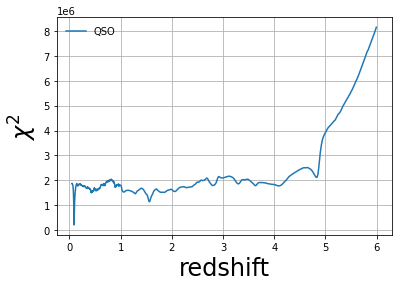

In [126]:

for template in [dtemplates[1]]:
    full_type = template.template.full_type
    plt.plot(zscan[target_id][full_type]['redshifts'],\
         zscan[target_id][full_type]['zchi2'],label=full_type)

plt.legend(loc=0,frameon=False)

plt.grid()
plt.xlabel("redshift",fontsize=24)
plt.ylabel("$\chi^2$",fontsize=24)

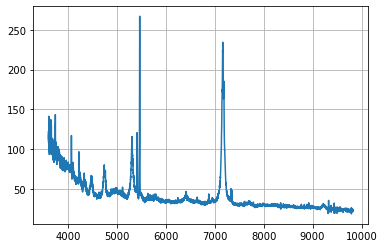

In [127]:
plt.plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0])
plt.grid()

In [128]:
print("Redrock thinks {} is a {} at redshift {}".format(target_id,zfit['spectype'][0],zfit['z'][0]))

Redrock thinks 9 is a QSO at redshift 0.09107560617522027


In [129]:
tid = target_id
t_qso = templates['QSO']

## several minima are stored in the zfit table
minumum_number = 0

## select the target id and minumum number
w = (zfit[:]['targetid']==tid) & (zfit[:]['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z']

## compute the best fit:
fit = t_qso.eval(coeff[:4],spec_combined.wave['brz'],zbest)

## remultiply by (1+z)
fit *= (1+zbest)

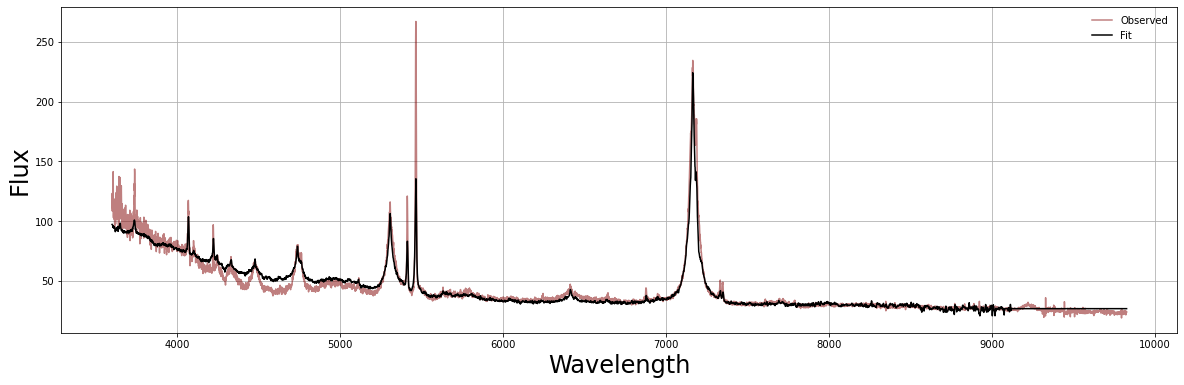

In [130]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux = spec_combined.flux['brz'][0]
plt.plot(wave,flux, 'maroon', label = 'Observed', alpha = .5)
plt.plot(wave,fit, 'black', label = 'Fit')
plt.xlabel("Wavelength", fontsize=24)
plt.ylabel("Flux", fontsize=24)
plt.grid(True)
plt.legend(loc=0, frameon=False)

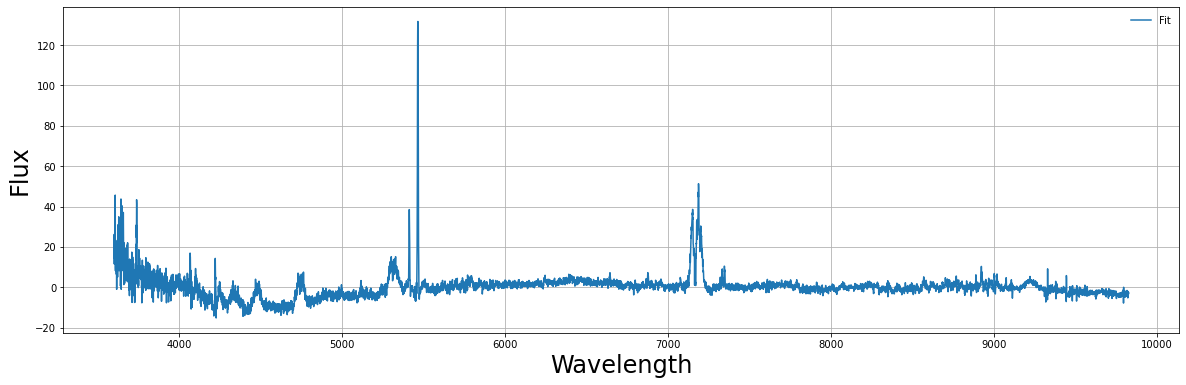

In [131]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux = spec_combined.flux['brz'][0]
#plt.plot(wave,flux, 'black', label = 'Observed')
plt.plot(wave,- fit + spec_combined.flux['brz'][0], label = 'Fit')
plt.xlabel("Wavelength", fontsize=24)
plt.ylabel("Flux", fontsize=24)
plt.grid(True)
plt.legend(loc=0, frameon=False)

In [132]:
y = -fit + spec_combined.flux['brz'][0]

# Trying to remove the fit and feed that into redrock

In [133]:
spectrum = Spectrum(spec_combined.wave['brz'], y, 
                    spec_combined.ivar['brz'][0], dense_array)

In [40]:
# Simulate a target with a single spectrum
target_id = 9
target = Target(target_id, [spectrum])

# Simulate distributed targets with a single target
# Note: You might need to initialize MPI before using this code
#       or modify the DistTargetsCopy class accordingly if MPI is not used.

dtargets = DistTargetsCopy([target])

In [41]:
dwave = dtargets.wavegrids()
dtemplates = load_dist_templates(dwave)
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 10 templates: 0.1 seconds
Rebinning templates: 10.8 seconds


In [42]:
dtemplates[0]

In [43]:
zscan, zfit = zfind(dtargets, [dtemplates[0]])

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.5 seconds
  Finding best fits for template GALAXY
    Finished in: 0.3 seconds


In [44]:
zfit

targetid,z,zerr,zwarn,chi2,zz [15],zzchi2 [15],coeff [10],npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64,float64,float64,int64,str6,str20,int64,int64,float64
9,0.0909256130950532,4.599796174594843e-06,0,111193.38058274984,0.08999142349732625 .. 0.09149834300269899,124820.61384817804 .. 122149.19093368814,360.3409138997474 .. -865.2231300023752,7774,GALAXY,,10,0,35532.10533648729
9,0.4378566462542341,2.024128549924443e-05,0,146725.48591923714,0.4368885389940409 .. 0.4388750457864603,147727.9002169455 .. 148336.64287487927,1604.9354137105965 .. 224.57517036290673,7774,GALAXY,,10,1,1554.6894456744194
9,0.4269029883442233,2.2907870846123528e-05,4,148280.17536491156,0.4260116735965327 .. 0.42798314305905083,149001.54937403678 .. 149566.43417129735,1911.8654966312404 .. 304.18750384123786,7774,GALAXY,,10,2,0.0


Text(0, 0.5, '$\\chi^2$')

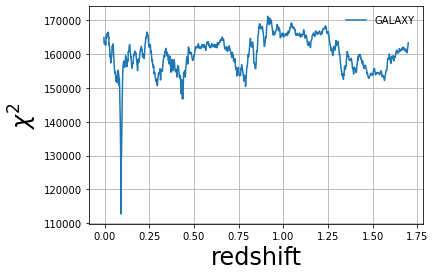

In [45]:
for template in [dtemplates[0]]:
    full_type = template.template.full_type
    #plt.figure(figsize = (20,6))
    plt.plot(zscan[target_id][full_type]['redshifts'],\
         zscan[target_id][full_type]['zchi2'],label=full_type)

plt.legend(loc=0,frameon=False)

plt.grid()
plt.xlabel("redshift",fontsize=24)
plt.ylabel("$\chi^2$",fontsize=24)

In [49]:
print("Redrock thinks {} is a {} at redshift {}".format(target_id,zfit['spectype'][0],zfit['z'][0]))

Redrock thinks 9 is a GALAXY at redshift 0.0909256130950532


In [62]:
tid = target_id
t_qso = templates['GALAXY']

## several minima are stored in the zfit table
minumum_number = 1

## select the target id and minumum number
w = (zfit['targetid']==tid) & (zfit['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z']

## compute the best fit:
fit = t_qso.eval(coeff,spec_combined.wave['brz'],zbest)

## remultiply by (1+z)
fit *= (1+zbest)

In [63]:
zbest

0.4378566462542341


Text(0, 0.5, 'Flux')

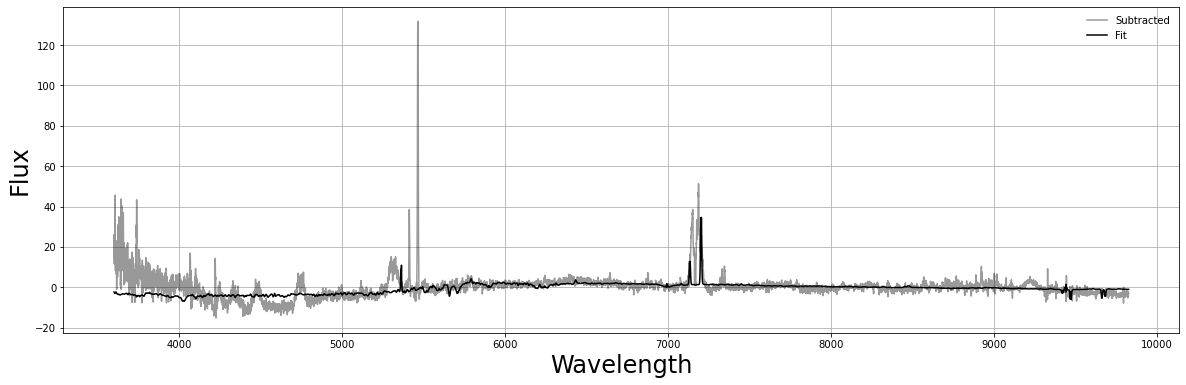

In [64]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux = spec_combined.flux['brz'][0]
plt.plot(wave,y, 'k-', label = 'Subtracted', alpha = .4)
plt.plot(wave,fit, 'k-', label = 'Fit')

plt.legend(loc = 0, frameon = False)

plt.grid()
plt.xlabel("Wavelength",fontsize=24)
plt.ylabel("Flux",fontsize=24)

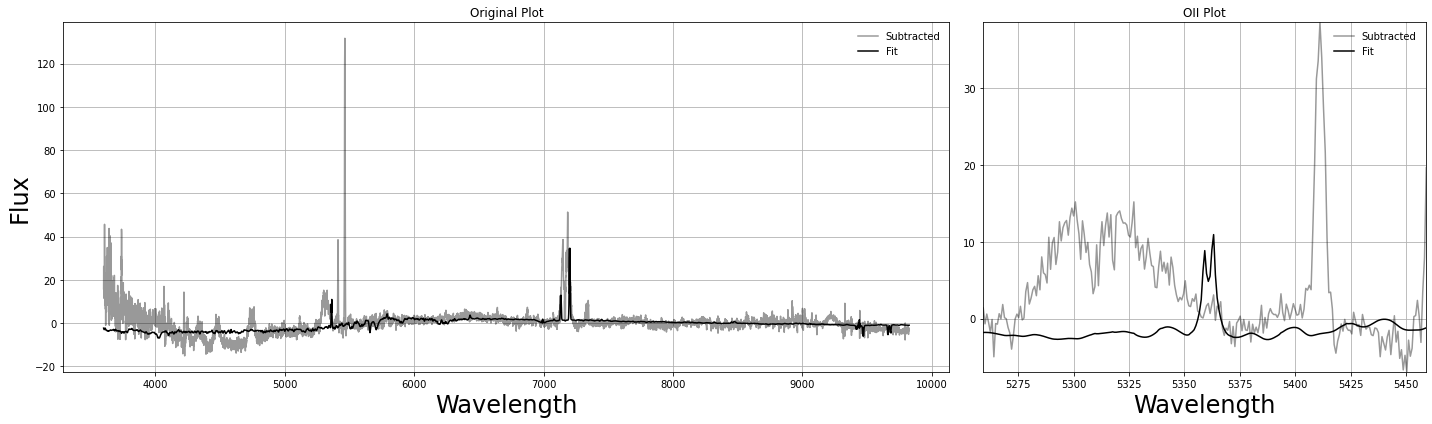

In [65]:
import matplotlib.gridspec as gridspec

# Define the x-range for the zoomed-in section
x_min = 3727 * (1 + zbest) - 100
x_max = 3727 * (1 + zbest) + 100
x_indices = np.where((wave >= x_min) & (wave <= x_max))
max_y_within_x_range = np.max(y[x_indices])
min_y_within_x_range = np.min(y[x_indices])

# Create a figure with two sections using gridspec
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Plot the original data on the left section
ax0 = plt.subplot(gs[0])
ax0.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax0.plot(wave, fit, 'k-', label='Fit')
ax0.set_xlabel("Wavelength", fontsize=24)
ax0.set_ylabel("Flux", fontsize=24)
ax0.grid(True)
ax0.legend(loc=0, frameon=False)
ax0.set_title('Original Plot')

# Plot the zoomed-in data on the right section
ax1 = plt.subplot(gs[1])
ax1.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax1.plot(wave, fit, 'k-', label='Fit')
ax1.set_xlabel("Wavelength", fontsize=24)
ax1.grid(True)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(min_y_within_x_range, max_y_within_x_range)
ax1.legend(loc=0, frameon=False)
ax1.set_title('OII Plot')

plt.tight_layout()
plt.show()

# Masking

In [134]:
zfit['z'][0]

0.09107560617522027

In [135]:
from scipy.interpolate import interp1d

def mask_QSO(wave, flux, ivar, l_width, redshift):
    '''
    Hard-coded mask for QSO broad emissions. The line width parameter allows to stretch the masks.
    
    Parameters:
        wave: Wavelength array
        flux: Flux array
        ivar: Inverse variance array
        l_width: Typical line width of QSO broad emissions
        redshift: Redshift value of the QSO
    Returns:
        flux_masked: Flux array with masked regions interpolated and large errors applied
        ivar_masked: Inverse variance array with interpolated values and large errors
    '''

    # Define the lines and their relative widths, adjusted for redshift
    lines = np.array([1215.668, 1240, 1400.0, 1549.0, 1640.0, 1909.0, 2326.0, 
                      2382.765, 2427, 2600.173, 2798.0, 3426.0, 3727, 3869, 
                      4101, 4340, 4861, 4959, 5007, 6562.81, 6816, 6734]) * (1 + redshift)
    widths = np.array([2.5, 0.5, 1.5, 2, 1, 1, 1, 1, 1, 1, 2.5, 0.5, 1.5, 
                       10.5, 10.5, 10.5, 10, 1, 2, 3, 1, 1])

    # Define masking ranges based on the line widths
    start_stop_table = np.array([lines - widths * l_width, lines + widths * l_width]).T

    # Interpolate over the masked regions and assign large errors
    flux_masked = flux.copy()
    ivar_masked = ivar.copy()
    for start, stop in start_stop_table:
        mask = (wave >= start) & (wave <= stop)
        if np.any(mask):
            # Interpolate over masked regions
            interp_func = interp1d(wave[~mask], flux[~mask], kind='linear', fill_value='extrapolate')
            flux_masked[mask] = interp_func(wave[mask])
            # Assign large errors to masked regions in the ivar array
            ivar_masked[mask] = 1.0 / 1e20  # Adjust the value as needed
    
    return flux_masked, ivar_masked



flux_masked, ivar_masked = mask_QSO(spec_combined.wave['brz'], y, spec_combined.ivar['brz'][0], 20, zfit['z'][0])

/tmp/ipykernel_1393212/221047261.py:30: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(wave, 1/np.sqrt(ivar_masked), label='Inverse Variance', color='green')


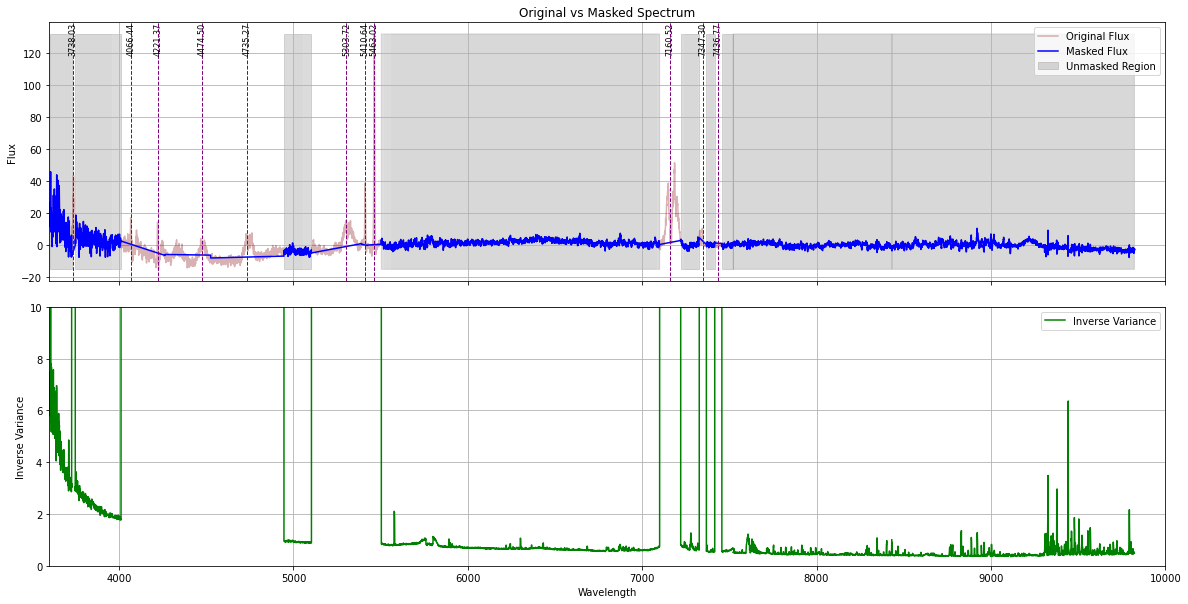

In [154]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Main plot
ax1.plot(wave, y, label='Original Flux', color='maroon', alpha=0.3)
ax1.plot(wave, flux_masked, label='Masked Flux', color='Blue')
ax1.fill_between(wave, y.min(), y.max(), where=ivar_masked > 1.0/1e20, color='grey', alpha=0.3, label='Unmasked Region')

lines = np.array([1215.668, 1240, 1400.0, 1549.0, 1640.0, 1909.0, 2326.0,
                  2382.765, 2427, 2600.173, 2798.0, 3426.0, 3727, 3869,
                  4101, 4340, 4861, 4959, 5007, 6562.81, 6816, 6734]) * (1 + 0.09107560617522027)
widths = np.array([2.5, 0.5, 1.5, 2, 1, 1, 1, 1, 1, 1, 2.5, 0.5, 1.5,
                   10.5, 10.5, 10.5, 10, 1, 2, 3, 1, 1])

# Define masking ranges based on the line positions and widths
for line, width in zip(lines, widths):
    start = line - width * 25
    stop = line + width * 25
    if start >= 3600 and stop <= 10000:
        ax1.axvspan(start, stop, color='white', alpha=0.1)
        ax1.axvline(x=line, color='purple', linestyle='--', linewidth=1)  # Add vertical lines for each line position
        ax1.text(line, ax1.get_ylim()[1], f'{line:.2f}', fontsize=8, rotation=90, verticalalignment='top', horizontalalignment='center')  # Add value as heading

ax1.set_ylabel('Flux')
ax1.set_title('Original vs Masked Spectrum')
ax1.set_xlim(3600, 10000)
ax1.legend()
ax1.grid(True)

# Subplot for ivar
ax2.plot(wave, 1/np.sqrt(ivar_masked), label='Inverse Variance', color='green')
ax2.set_xlabel('Wavelength')
ax2.set_ylabel('Inverse Variance')
ax2.set_ylim(0, 10)
ax2.legend()
ax2.grid(True)

plt.subplots_adjust(hspace=0.1)  # Adjust the vertical spacing between subplots
plt.show()

In [137]:
len(ivar_masked), len(flux_masked)

(7781, 7781)

In [138]:
spectrum = Spectrum(spec_combined.wave['brz'], flux_masked, 
                    ivar_masked, dense_array)

In [139]:
# Simulate a target with a single spectrum
target_id = 9
target = Target(target_id, [spectrum])

# Simulate distributed targets with a single target
# Note: You might need to initialize MPI before using this code
#       or modify the DistTargetsCopy class accordingly if MPI is not used.

dtargets = DistTargetsCopy([target])

In [140]:
dwave = dtargets.wavegrids()
dtemplates = load_dist_templates(dwave)
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 10 templates: 0.1 seconds
Rebinning templates: 12.1 seconds


In [141]:
zscan, zfit = zfind(dtargets, [dtemplates[0]])

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.5 seconds
  Finding best fits for template GALAXY
    Finished in: 0.3 seconds


In [142]:
zfit

targetid,z,zerr,zwarn,chi2,zz [15],zzchi2 [15],coeff [10],npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64,float64,float64,int64,str6,str20,int64,int64,float64
9,1.336757002510525,1.6619453068808617e-05,0,54638.346276283264,1.3351946163730322 .. 1.338423036560929,55061.39593871647 .. 56057.6590246657,-3970.815686644931 .. -363.95554884447677,7774,GALAXY,,10,0,1167.2571544647217
9,1.478500318586185,4.17152065559413e-05,0,55805.603430747986,1.4764130316909783 .. 1.4798366871623583,56048.179814832685 .. 56013.5182128559,-1824.634578568199 .. -130.209279201077,7774,GALAXY,,10,1,491.73087978363037
9,1.393524540031125,1.5313388133385997e-05,4,56297.334310531616,1.3923409860068983 .. 1.395648411384383,57441.207902291186 .. 57815.606690724104,-5222.571539495469 .. -411.32975411940885,7774,GALAXY,,10,2,0.0


In [146]:
tid = target_id
t_qso = templates['GALAXY']

## several minima are stored in the zfit table
minumum_number = 1

## select the target id and minumum number
w = (zfit['targetid']==tid) & (zfit['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z']

## compute the best fit:
fit = t_qso.eval(coeff,spec_combined.wave['brz'],zbest)

## remultiply by (1+z)
fit *= (1+zbest)

Text(0, 0.5, 'Flux')

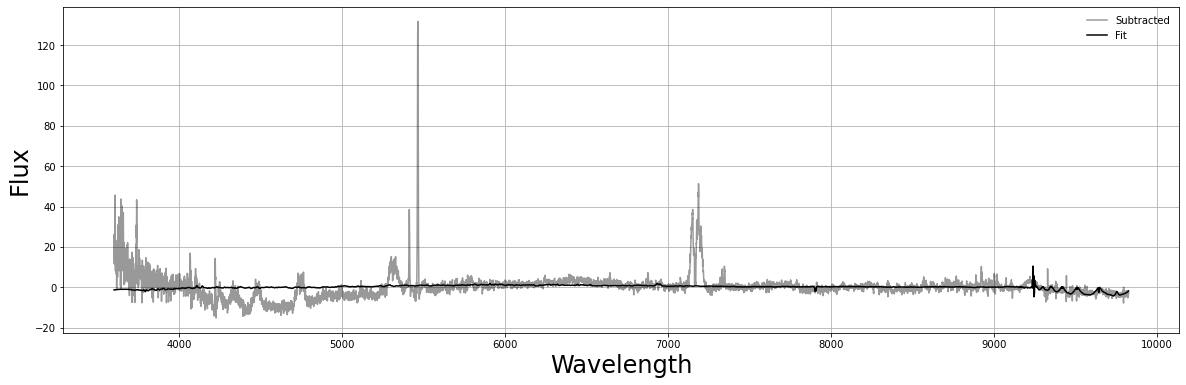

In [147]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux = spec_combined.flux['brz'][0]
plt.plot(wave,y, 'k-', label = 'Subtracted', alpha = .4)
plt.plot(wave,fit, 'k-', label = 'Fit')

plt.legend(loc = 0, frameon = False)

plt.grid()
plt.xlabel("Wavelength",fontsize=24)
plt.ylabel("Flux",fontsize=24)

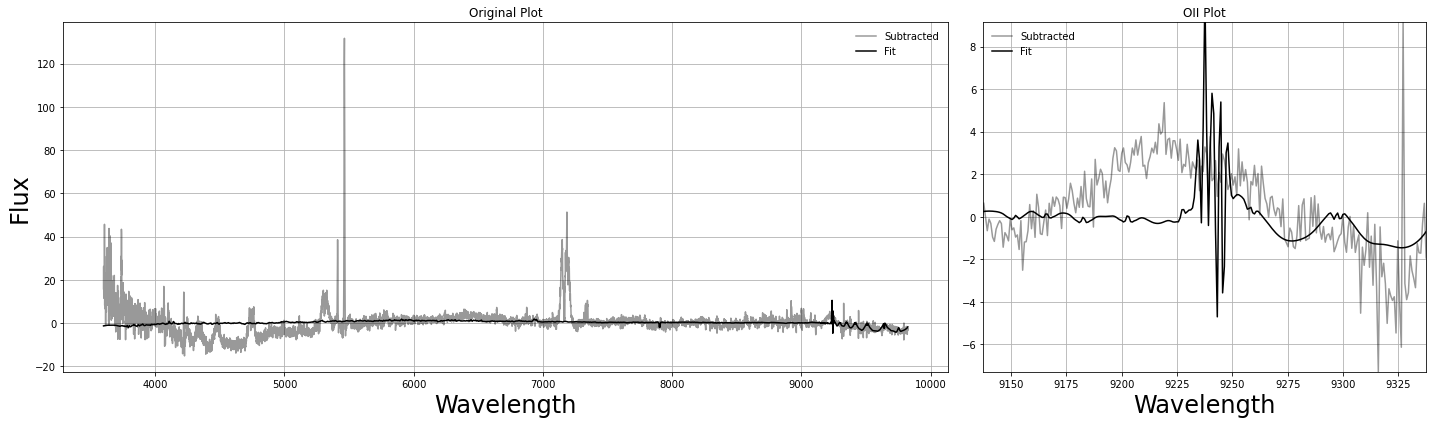

In [148]:
import matplotlib.gridspec as gridspec

# Define the x-range for the zoomed-in section
x_min = 3727 * (1 + zbest) - 100
x_max = 3727 * (1 + zbest) + 100
x_indices = np.where((wave >= x_min) & (wave <= x_max))
max_y_within_x_range = np.max(y[x_indices])
min_y_within_x_range = np.min(y[x_indices])

# Create a figure with two sections using gridspec
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Plot the original data on the left section
ax0 = plt.subplot(gs[0])
ax0.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax0.plot(wave, fit, 'k-', label='Fit')
ax0.set_xlabel("Wavelength", fontsize=24)
ax0.set_ylabel("Flux", fontsize=24)
ax0.grid(True)
ax0.legend(loc=0, frameon=False)
ax0.set_title('Original Plot')

# Plot the zoomed-in data on the right section
ax1 = plt.subplot(gs[1])
ax1.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax1.plot(wave, fit, 'k-', label='Fit')
ax1.set_xlabel("Wavelength", fontsize=24)
ax1.grid(True)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(min_y_within_x_range, max_y_within_x_range)
ax1.legend(loc=0, frameon=False)
ax1.set_title('OII Plot')

plt.tight_layout()
plt.show()